In [1]:
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

In [2]:
# Manage Randomness
SEED = 99
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

## Sample loading of images

In [3]:
!ls sagar_data/A

21050078.BMP  21050512.BMP  21050889.BMP  21060297.BMP	21060464.BMP
21050119.BMP  21050681.BMP  21060025.BMP  21060352.BMP	21060520.BMP
21050267.BMP  21050682.BMP  21060226.BMP  21060390.BMP
21050272.BMP  21050683.BMP  21060262.BMP  21060426.BMP


BMP
(1024, 768)
RGB


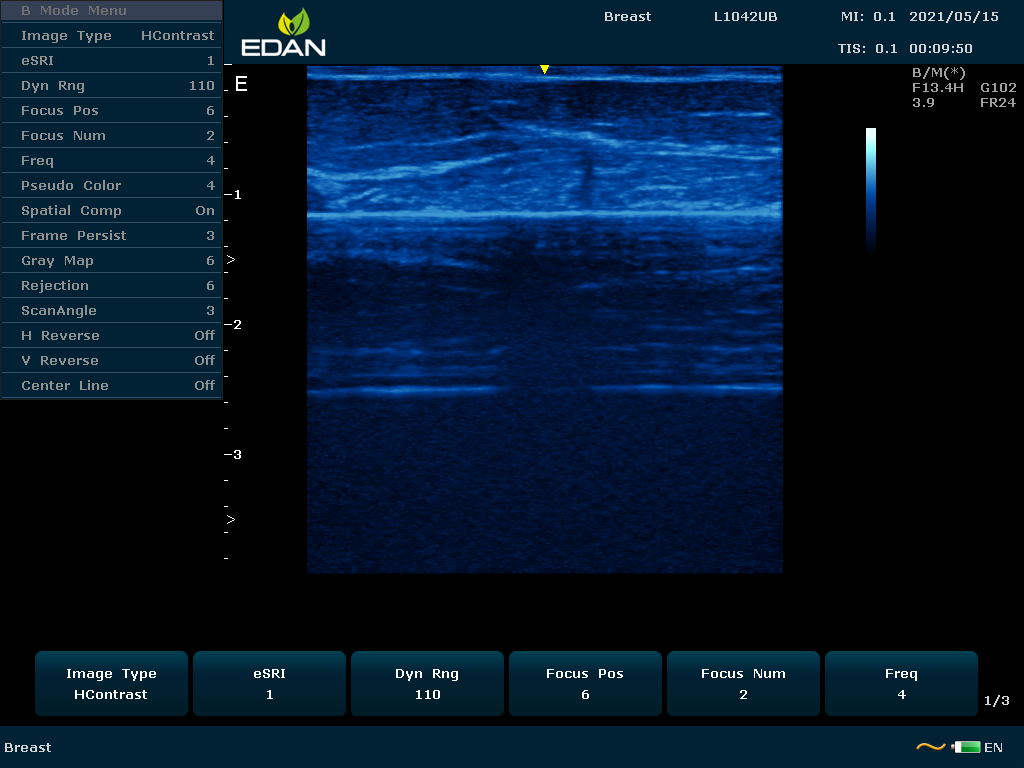

In [4]:
sample_image = Image.open('./sagar_data/A/21050078.BMP')
print(sample_image.format)
print(sample_image.size)
print(sample_image.mode)

sample_image

## Load images and preprocess

(768, 1024, 3)
(490, 490, 3)
255 0
<class 'numpy.uint8'>


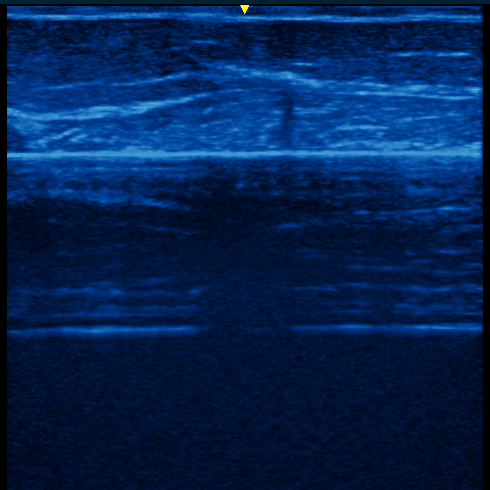

In [5]:
def image_cropper(image):
    #print(image.shape)
    cropped_image = []
    cropped_image.append(image[60:550,300:790,])
    cropped_image = np.squeeze(np.array(cropped_image))
    return cropped_image

# verify that this works as expected
sample_image= np.asarray(sample_image)
print(sample_image.shape)
sample_cropped = image_cropper(sample_image)
print(sample_cropped.shape)
print(np.max(sample_cropped), np.min(sample_cropped))
print(type(sample_cropped[0][0][0]))
sample_cropped_image = Image.fromarray((sample_cropped).astype(np.uint8))
sample_cropped_image.show()

(490, 490)
225.92999999999998 0.0


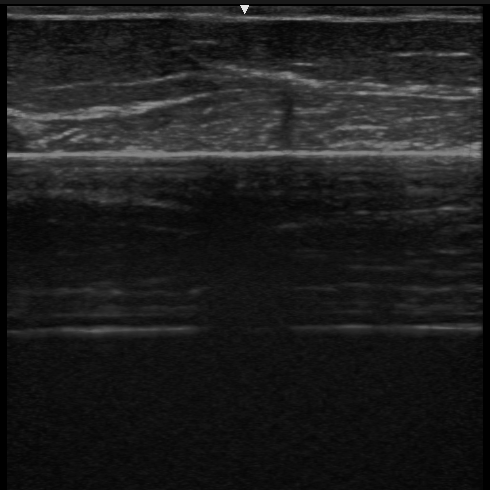

In [6]:
## Convert Image to grayscape
def image_grayscaler(rgb_image):
    #gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray = np.dot(rgb_image[...,:3], [0.299, 0.587, 0.114])
    return gray

# Veryfy grayscaling
grayscaled = image_grayscaler(sample_cropped)
print(grayscaled.shape)
print(np.max(grayscaled), np.min(grayscaled))
grayscaled_image = Image.fromarray((grayscaled).astype(np.uint8))
grayscaled_image.show()

In [7]:
# Z-score normalization single channel
def image_normalizer(regular_image):
    mean = np.mean(regular_image)
    std = np.std(regular_image)
    #print(mean, std)
    normalized_image = (regular_image - mean)/ std
    return normalized_image

normalized = image_normalizer(grayscaled)
print(np.max(normalized), np.min(normalized))

8.305680122634215 -1.262181770184304


In [8]:
background_image_paths = glob.glob('./sagar_data/A/*.BMP')
background_images =[]
for image_path in background_image_paths:
    background_images.append(
        #image_normalizer(
            image_grayscaler(
                image_cropper(np.asarray(Image.open(image_path)))))
    
background_images = np.asarray(background_images)
background_images.shape

(18, 490, 490)

In [9]:
class_b_image_paths = glob.glob('./sagar_data/B/*.BMP')
class_b_images =[]
for image_path in class_b_image_paths:
    class_b_images.append(
        #image_normalizer(
            image_grayscaler(
                image_cropper(np.asarray(Image.open(image_path)))))
class_b_images = np.asarray(class_b_images)
class_b_images.shape

(23, 490, 490)

In [10]:
class_c_image_paths = glob.glob('./sagar_data/C/*.BMP')
class_c_images =[]
for image_path in class_c_image_paths:
    class_c_images.append(
        #image_normalizer(
            image_grayscaler(
                image_cropper(np.asarray(Image.open(image_path)))))
class_c_images = np.asarray(class_c_images)
class_c_images.shape

(23, 490, 490)

In [11]:
# create labels 
background_labels = np.full((background_images.shape[0]), 0)

class_b_labels = np.full((class_b_images.shape[0]), 1)
class_c_labels = np.full((class_c_images.shape[0]), 2)

labels_for_images_of_samples = np.squeeze(np.concatenate((class_b_labels, class_c_labels), axis=0))

print(background_labels)
print(class_b_labels)
print(class_c_labels)
print(labels_for_images_of_samples)
print(type(background_labels[0]))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]
<class 'numpy.int64'>


In [12]:
# Combine images of samples
images_of_samples = np.concatenate((class_b_images, class_c_images), axis=0)
images_of_samples.shape

# Randomly shuffle
PERMUTATION = np.random.randint(0,images_of_samples.shape[0], size = (1,images_of_samples.shape[0]))
print(PERMUTATION)
print(PERMUTATION.shape)

images_of_samples = np.squeeze(images_of_samples[PERMUTATION])
labels_for_samples = np.squeeze(labels_for_images_of_samples[PERMUTATION])
 
print(images_of_samples.shape)
print(labels_for_samples.shape)

[[ 1 35 40  9 40 18  4  5  1 23 35  1 29 38 43 23  2  0 12 40  8 20 39 15
  27 37 36 44 17  9 32 21 41 35 19 22 26  5 12 32 27  1 44 11 11 29]]
(1, 46)
(46, 490, 490)
(46,)


In [13]:
## Define Hyper-paramters
# Both
LEARNING_RATE = 0.001

# Pre-training: 
PRETRAIN_BATCH_SIZE = 3
PRETRAIN_EPOCHS = 2

# Fine-tuning
FINE_TUNE_BATCH_SIZE = 1
TRAIN_RATIO = 0.7
FINE_TUNE_EPOCHS = 5

criterion = nn.CrossEntropyLoss()

## Create Datasets

In [14]:
# Make data PyTorch Compatible
background_images_tensor = torch.from_numpy(np.expand_dims(background_images, axis=1)).type(torch.FloatTensor)
background_labels_torch = torch.LongTensor(background_labels)

print("....................")
print("Data for pre-train", background_images_tensor.shape)
print("Labels for pre-train", background_labels_torch.shape)

train_len = int(TRAIN_RATIO*len(images_of_samples))
      
train_data = images_of_samples[0:train_len]
train_data_tensor = torch.from_numpy(np.expand_dims(train_data, axis=1)).type(torch.FloatTensor)

train_labels = labels_for_samples[0:train_len]
train_labels_torch = torch.LongTensor(train_labels)

print("....................")
print("Train Data for Fine tuning:", train_data_tensor.shape)
print("Labels for pre-train", train_labels_torch.shape)

test_data = images_of_samples[train_len:len(images_of_samples)]
test_data_tensor = torch.from_numpy(np.expand_dims(test_data, axis=1)).type(torch.FloatTensor)

test_labels = labels_for_samples[train_len:len(images_of_samples)]
test_labels_torch = torch.LongTensor(test_labels)

print("....................")
print("Test Data After Fine tuning:", test_data_tensor.shape)
print("Labels for pre-train", test_labels_torch.shape)

....................
Data for pre-train torch.Size([18, 1, 490, 490])
Labels for pre-train torch.Size([18])
....................
Train Data for Fine tuning: torch.Size([32, 1, 490, 490])
Labels for pre-train torch.Size([32])
....................
Test Data After Fine tuning: torch.Size([14, 1, 490, 490])
Labels for pre-train torch.Size([14])


In [15]:
background_dataset = torch.utils.data.TensorDataset(background_images_tensor, background_labels_torch)
background_data_loader = torch.utils.data.DataLoader(dataset=background_dataset,
                                               batch_size=PRETRAIN_BATCH_SIZE,
                                               shuffle=False)

train_dataset = torch.utils.data.TensorDataset(train_data_tensor, train_labels_torch)
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=FINE_TUNE_BATCH_SIZE,
                                               shuffle=True)

test_dataset = torch.utils.data.TensorDataset(test_data_tensor, test_labels_torch)
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=FINE_TUNE_BATCH_SIZE,
                                               shuffle=True)

## Create a Convolutional Neural Network

In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 3, 20, stride=2, padding=0)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(3, 6, 60, stride=1, padding=0),
            nn.Flatten() )
        
        self.fc1 = nn.Linear(20886, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 10)
        self.fc6 = nn.Linear(10, 3)
        

    def forward(self, x):
        #print( "Input", x.shape)
        
        x = self.conv1(x)
        #print("Conv1", x.shape)
        
        x = self.maxpool(x)
        #print("Maxpool", x.shape)
        
        x = self.conv2(x)
        #print("Conv2 + Flatten", x.shape)
        
        x = self.fc1(x)
        x = F.relu(x)
        #print("FC1 + Relu", x.shape)
        
        x = self.fc2(x)
        x = F.relu(x)
        #print("FC2 + Relu", x.shape)
        
        x = self.fc3(x)
        x = F.relu(x)
        #print("FC3 + Relu", x.shape)
        
        x = self.fc4(x)
        x = F.relu(x)
        #print("FC4 + Relu", x.shape)
        
        x = self.fc5(x)
        x = F.relu(x)
        #print("FC5 + Relu", x.shape)
        
        x = self.fc6(x)
        x = F.relu(x)
        #print("FC6 + Relu", x.shape)
        
        return x

In [17]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Pre-train on images of the background

In [18]:
pre_train_loss = []
for e in range(PRETRAIN_EPOCHS):
    for bi, data in enumerate(background_data_loader):
        print(bi)
        inputs_batch, labels_batch = data
        optimizer.zero_grad()
        outputs = model(inputs_batch)
        print(outputs)
        
        loss = criterion(outputs, labels_batch)
        pre_train_loss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()

0
tensor([[0.2257, 0.2343, 0.0000],
        [0.1950, 0.2088, 0.0000],
        [0.2029, 0.2417, 0.0000]], grad_fn=<ReluBackward0>)
1
tensor([[77.6107,  0.0000, 28.2173],
        [51.0697,  0.0000, 18.2121],
        [63.3289,  0.0000, 22.4535]], grad_fn=<ReluBackward0>)
2
tensor([[210.0080,   0.0000,  77.6431],
        [216.4002,   0.0000,  80.1675],
        [187.3535,   0.0000,  70.0015]], grad_fn=<ReluBackward0>)
3
tensor([[416.7617,   0.0000, 158.4970],
        [341.4057,   0.0000, 130.0131],
        [414.3588,   0.0000, 157.3179]], grad_fn=<ReluBackward0>)
4
tensor([[609.7922,   0.0000, 234.1838],
        [519.1541,   0.0000, 199.6030],
        [819.8680,   0.0000, 314.2127]], grad_fn=<ReluBackward0>)
5
tensor([[ 891.2371,    0.0000,  345.0872],
        [1258.9672,    0.0000,  487.3102],
        [ 708.3116,    0.0000,  274.4530]], grad_fn=<ReluBackward0>)
0
tensor([[1566.9294,    0.0000,  606.8416],
        [2761.8374,    0.0000, 1071.0830],
        [1803.5350,    0.0000,  700.1295]]

Text(0, 0.5, 'Cross Entropy Loss')

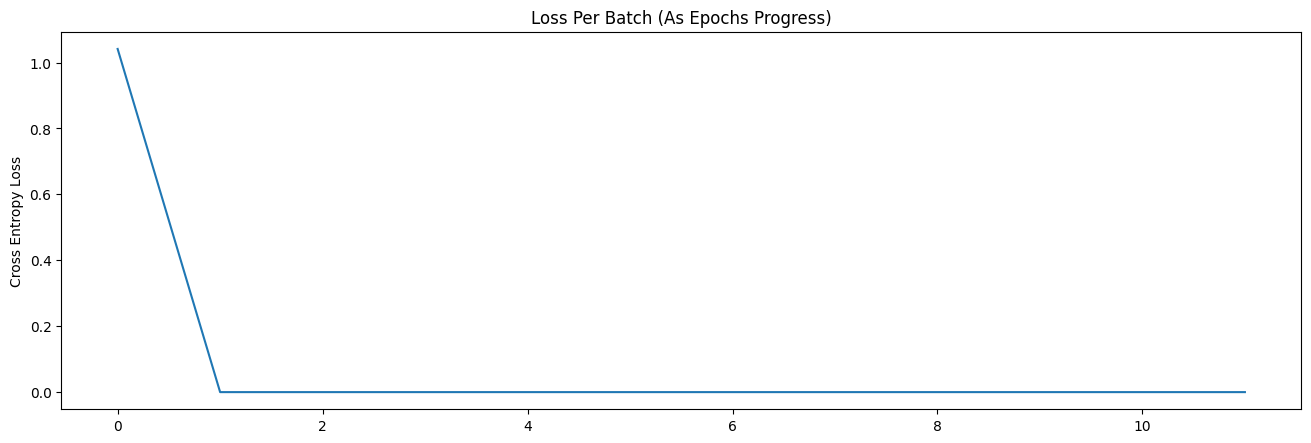

In [19]:
# Pre-train loss per batch (in totality of epochs)
fig, ax = plt.subplots(figsize=(16,5), dpi=100)
ax.plot(pre_train_loss)
ax.set_title("Loss Per Batch (As Epochs Progress)")
ax.set_ylabel("Cross Entropy Loss")

## Fine tune on class images

In [20]:
fine_tune_loss = []
for e in range(FINE_TUNE_EPOCHS):
    for bi, data in enumerate(train_data_loader):
        print(bi)
        inputs_batch, labels_batch = data
        optimizer.zero_grad()
        outputs = model(inputs_batch)
        print(outputs)
        
        loss = criterion(outputs, labels_batch)
        fine_tune_loss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()

0
tensor([[874.8193,   0.0000, 348.5289]], grad_fn=<ReluBackward0>)
1
tensor([[15027.8438,     0.0000,  7164.8740]], grad_fn=<ReluBackward0>)
2
tensor([[4606.1753,    0.0000, 2247.2358]], grad_fn=<ReluBackward0>)
3
tensor([[57.0228,  0.0000, 29.5212]], grad_fn=<ReluBackward0>)
4
tensor([[644.8678,   0.0000, 448.3407]], grad_fn=<ReluBackward0>)
5
tensor([[108.1453,  13.4228, 102.3063]], grad_fn=<ReluBackward0>)
6
tensor([[0., 0., 0.]], grad_fn=<ReluBackward0>)
7
tensor([[ 0.0000,  0.0000, 47.2304]], grad_fn=<ReluBackward0>)
8
tensor([[0., 0., 0.]], grad_fn=<ReluBackward0>)
9
tensor([[ 0.0000,  0.0000, 16.0763]], grad_fn=<ReluBackward0>)
10
tensor([[0., 0., 0.]], grad_fn=<ReluBackward0>)
11
tensor([[0., 0., 0.]], grad_fn=<ReluBackward0>)
12
tensor([[0., 0., 0.]], grad_fn=<ReluBackward0>)
13
tensor([[0., 0., 0.]], grad_fn=<ReluBackward0>)
14
tensor([[0., 0., 0.]], grad_fn=<ReluBackward0>)
15
tensor([[0., 0., 0.]], grad_fn=<ReluBackward0>)
16
tensor([[0., 0., 0.]], grad_fn=<ReluBackward0>)

31
tensor([[0., 0., 0.]], grad_fn=<ReluBackward0>)


Text(0, 0.5, 'Cross Entropy Loss')

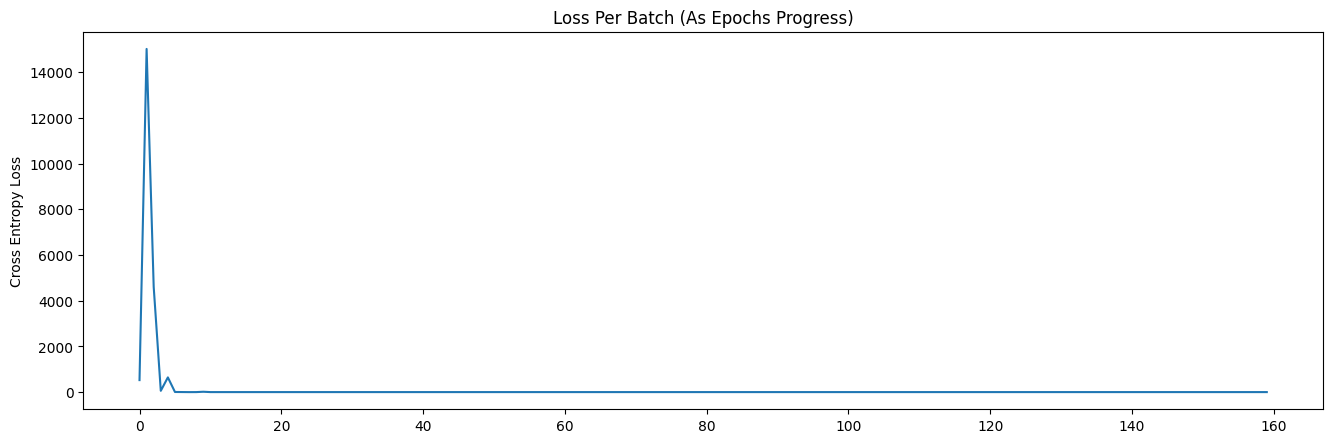

In [21]:
fig, ax = plt.subplots(figsize=(16,5), dpi=100)
ax.plot(fine_tune_loss)
ax.set_title("Loss Per Batch (As Epochs Progress)")
ax.set_ylabel("Cross Entropy Loss")

## Moment of Truth: Test

In [22]:
total_tested = 0
correct = 0

with torch.no_grad():
    for bi, data in enumerate(test_data_loader):
        print("\n")
        inputs_batch, labels_batch = data
        
        print("Ground Truth ", labels_batch)
        
        total_tested += labels_batch.size(0)
        
        outputs = model(inputs_batch)
        
        print("Öutput ", outputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        print("Prediction: ", predicted)
        
        correct += (predicted == labels_batch).sum().item()
 
print("Total tested: ",total_tested)
print("Correct: ",correct)
print("Accuracy {}%".format(round(100*correct/total_tested,2) ))



Ground Truth  tensor([1])
Öutput  tensor([[0., 0., 0.]])
Prediction:  tensor([0])


Ground Truth  tensor([1])
Öutput  tensor([[0., 0., 0.]])
Prediction:  tensor([0])


Ground Truth  tensor([2])
Öutput  tensor([[0., 0., 0.]])
Prediction:  tensor([0])


Ground Truth  tensor([2])
Öutput  tensor([[0., 0., 0.]])
Prediction:  tensor([0])


Ground Truth  tensor([1])
Öutput  tensor([[0., 0., 0.]])
Prediction:  tensor([0])


Ground Truth  tensor([2])
Öutput  tensor([[0., 0., 0.]])
Prediction:  tensor([0])


Ground Truth  tensor([2])
Öutput  tensor([[0., 0., 0.]])
Prediction:  tensor([0])


Ground Truth  tensor([1])
Öutput  tensor([[0., 0., 0.]])
Prediction:  tensor([0])


Ground Truth  tensor([1])
Öutput  tensor([[0., 0., 0.]])
Prediction:  tensor([0])


Ground Truth  tensor([1])
Öutput  tensor([[0., 0., 0.]])
Prediction:  tensor([0])


Ground Truth  tensor([2])
Öutput  tensor([[0., 0., 0.]])
Prediction:  tensor([0])


Ground Truth  tensor([2])
Öutput  tensor([[0., 0., 0.]])
Prediction:  tens